In [2]:
from pathlib import Path
import torch
import numpy as np
import random
from data import sample_latents
from vis import visualize_latents, visualize_slots_and_output, visualize_output_grid, visualize_score_heatmaps
from models import InvertibleMLP, ParallelSlots, LinearComposition, CompositionalFunction

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [11]:
D = [2, 2]
M = [16, 16, 16]
grid_size = 11

z = sample_latents(D, "orthogonal", n_samples=10000, grid_size=grid_size)

if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
dev = torch.device(dev)

phi = ParallelSlots([InvertibleMLP(d_in, d_out, d_hidden=10) for d_in, d_out in zip(D, M)])
C = LinearComposition()
f = CompositionalFunction(C, phi).to(dev)
f.eval()
with torch.no_grad():
    x = f(z.to(dev)).to("cpu")

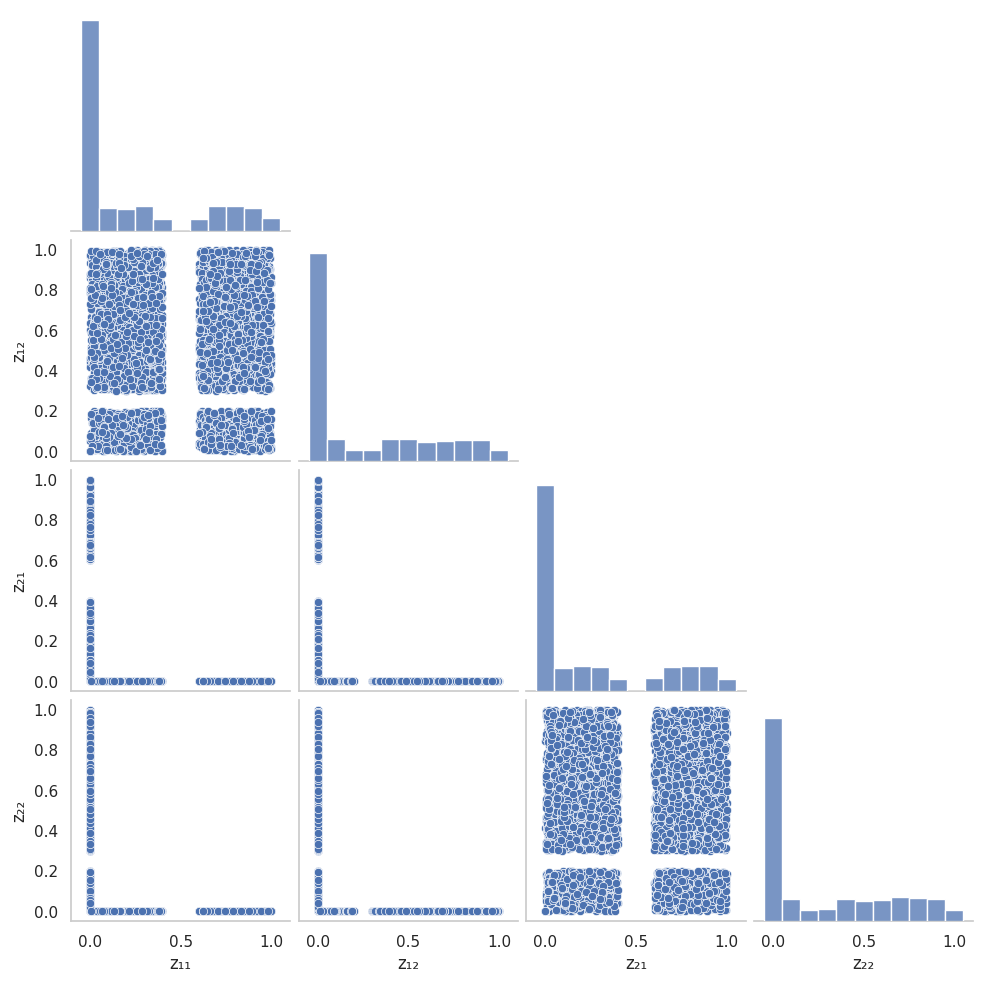

In [47]:
from typing import List, Tuple
from data import _sample_orthogonal

def _sample_orthogonal_with_gap(n_samples: int, dim_per_slot: List[int], gaps: List[Tuple[int, float, float]]) -> torch.Tensor:    
    total_dim = sum(dim_per_slot)
    for (dim, start, stop) in gaps:
        assert dim in range[total_dim], f"Gap dimension must be in range({total_dim}), but got {dim}."
        assert start < stop, f"Gap start must be smaller than stop, but got [{start}, {stop}] for dim {dim}."
        assert start >= 0 and stop <= 1, f"Gap edges must be in [0, 1], but got [{start}, {stop}] for dim {dim}."
        assert stop - start < 1, f"Gap can't span entire range [0, 1] for dim {dim}."
    
    z = torch.Tensor(0, total_dim)

    while z.shape[0] < n_samples:
        # first sample normal orthogonal
        _z = _sample_orthogonal(n_samples, dim_per_slot)

        # then reject points
        mask = torch.ones(n_samples)
        for (dim, start, stop) in gaps:
            _mask = torch.logical_or(_z[:, dim] < start, _z[:, dim] > stop)
            mask = torch.logical_and(mask, _mask)
        
        idx = mask.nonzero().squeeze(1)
        z = torch.cat([z, _z[idx]])

    return z[:n_samples]

z = _sample_orthogonal_with_gap(10000, D, [(0, 0.4, 0.6), (1, 0.2, 0.3), (2, 0.4, 0.6), (3, 0.2, 0.3)])

visualize_latents(z, D, grid_size)

In [ ]:
visualize_latents(z, D, grid_size)

In [ ]:
visualize_slots_and_output(*f.to("cpu")(z[:10], return_slot_outputs=True))

In [ ]:
visualize_output_grid(f, 5, (0, 1), plot_size=1)

In [12]:
checkpoint = Path("/home/thaddaus/code/cood/_checkpoints/ADD_ortho_20230411-140849/latest.pt")

phi_hat = ParallelSlots(
        [
            InvertibleMLP(d_in, d_out, d_hidden=10)
            for d_in, d_out in zip(D, M)
        ]
    )
f_hat = CompositionalFunction(C, phi_hat)
f_hat.to(dev)

f_hat.load_state_dict(torch.load(checkpoint))
f_hat.eval()

with torch.no_grad():
    x_hat = f_hat(z.to(dev)).to("cpu")

err = (x_hat - x).pow(2).mean(dim=-1)

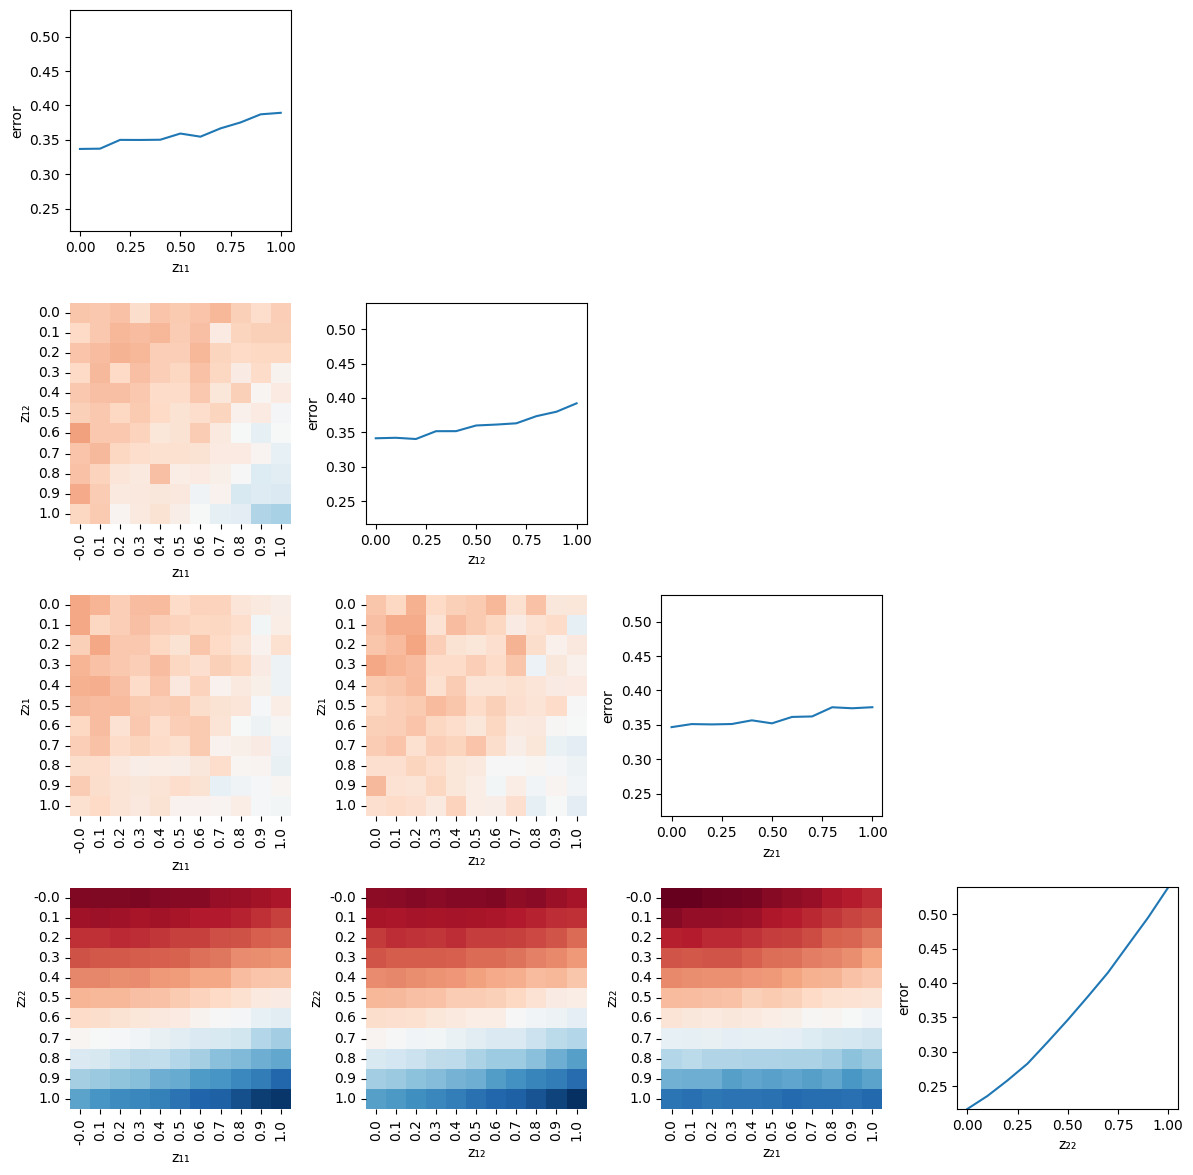

In [13]:
visualize_score_heatmaps(z, err, D, "error")